# Майнор Интеллектуальный анализ данных / Введение в анализ данных

## Домашнее задание 3. Логистическая регрессия и случайный лес.

В этом задании вам предстоит:
- поработать с логистической регрессией (полная реализация не потребуется, однако можно заработать бонусные баллы)
- воспроизвести подход случайного леса через одно решающее дерево, поэкспериментировать со случайным лесом.

На все вопросы требуется отвечать развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.
- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.04.2018
- Срок сдачи: 23:59 18.05.2018

In [1]:
%pylab inline
% matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Часть 0. Подготовка данных.

Для наших экспериентов возьмём обучающую выборку [отсюда](https://www.kaggle.com/iabhishekofficial/mobile-price-classification).

In [2]:
train = pd.read_csv('train.csv')

Решается задача многоклассовой классификации — определение ценовой категории телефона. Для простоты перейдём к задаче бинарной классификации — пусть исходные классы 0 и 1 соответствуют классу 0 новой целевой переменной, а остальные классу 1.

Замените целевую переменную, отделите её в отдельную переменную и удалите из исходной выборки.

In [3]:
y = train.price_range.replace([0, 1, 2, 3], [0, 0, 1, 1])
X = train.iloc[:, :-1]

Разделите выборку на обучающую и тестовую части в соотношении 7 к 3. Для этого можно использовать `train_test_split` из scikit-learn. Не забудьте зафиксировать сид для разбиения.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Часть 1. Логистическая регрессия.

[4 балла]

В этой части вы будете обучать самый простой бинарный классификатор — логистическую регрессию. Будем использовать готовую реализацию `LogisticRegression` из scikit-learn.

Логистическая регрессия — линейный метод, то есть в нём предсказание алгоритма вычислаяется как скалярное произведение признаков и весов алгоритма: 

$$
b(x) = w_0 + \langle w, x \rangle = w_0 + \sum_{i=1}^{d} w_i x_i
$$

Для вычисления вероятности положительного класса применяется сигмода. В результате предсказание вероятности принадлежности объекта к положительному классу можно записать как: 

$$
P(y = +1 | x) = \frac{1}{1 + \exp(- w_0 - \langle w, x \rangle )}
$$

Не забывайте, что для линейных методов матрицу объекты-признаки необходимо предварительно нормировать (то есть привести каждый признак к одному и тому же масштабу одним из способов). Для этого можно воспользоваться `StandardScaler` или сделать это вручную.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Обучите логистическую регрессию. Сделайте предсказания для тестовой части, посчитайте по ним ROC-AUC и Accuracy (порог 0.5). Хорошо ли удаётся предсказывать целевую переменную?

Не забывайте, что метод `predict_proba` вычисляет вероятности обоих классов выборки, а в бинарной классификации нас интересует в первую очередь вероятность принадлежности к положительному классу.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_score = lr.predict_proba(np.array(X_test))

y_pred = 1*(y_score[:, 1] > 0.5)

print("accuracy score: {0}".format(accuracy_score(y_test, y_pred)))
print("roc-auc score : {0}".format(roc_auc_score(y_test, y_score[:, 1])))

accuracy score: 0.9833333333333333
roc-auc score : 0.9997333066639997


 - <i>Целевую переменную хорошо удаётся предсказать, так как значения acuuracy и roc-auc очень близки к 1</i>

У обученной логистической регрессии есть два аттрибута: `coef_` и `intercept_`, которые соответствуют весам $w$ и $w_0$. Это и есть результат обучения логистической регрессии. Попробуйте с помощью них (с помощью всё той же обученной ранее логистической регрессии) посчитать "сырое" предсказание алгоритма $b(x)$. 

Постройте гистограмму полученных значений и ответьте на вопросы:
- Какие значения принимает такое предсказание?
- Похожи ли эти значения на вероятность классов?

Text(0,0.5,'Количество')

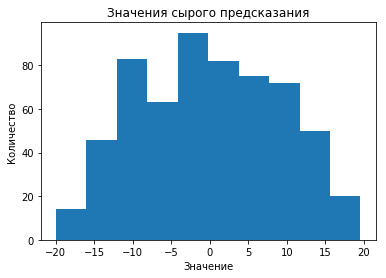

In [8]:
raw_y = []
for x in X_test:
    raw_y.append(np.dot(lr.coef_, x)[0] + lr.intercept_[0])

plt.hist(raw_y)
plt.title("Значения сырого предсказания")
plt.xlabel("Значение")
plt.ylabel("Количество")

Как видно из гистрограммы, сырое предсказание принимает значение от -20 до 20, что не похоже на вероятность классов по принимаемым значениям (вероятность классов лежит в отрезке $[0, 1]$).

Реализуйте сигмоиду и постройте её график. Что вы можете сказать об этой функции?

Text(0,0.5,'y')

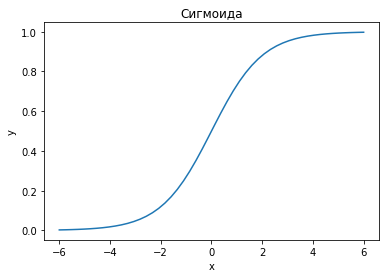

In [9]:
import math

def sigmoid(x):
    return 1/(1 + math.exp(-x))

x = np.linspace(-6, 6)
y = [sigmoid(cur_x) for cur_x in x ]
plt.plot(x, y)
plt.title('Сигмоида')
plt.xlabel('x')
plt.ylabel('y')

Сигмо́ида — это гладкая монотонная нелинейная функция, имеющая форму буквы "S", которая часто применяется для «сглаживания» значений некоторой величины. Возрастающая функция.
#### Применение в логистических функциях
Логистическая функция $f(x) = \frac{1}{1 + exp(-x)}$ используется в логистической регрессии следующим образом. В ней решается задача классификации с двумя классами ($y=0$ и $y=1$, где $y$ - переменная, указывающая класс объекта) и делается предположение о том, что вероятность принадлежности объекта к одному из классов выражается через значения приззнаков этого объекта $x_1, x_2, x_3, ..., x_n$ (действительные числа). Уравнение сигмоиды - непрерывная версия логистического отображения. Можно легко найти решение этого уравнения и получить две наиболее распространенных формы записи логистической зависимости после интегрирования, так как функция гладкая, имеет производные на всей области определения. 

Примените реализованную сигмоиду к $b(x)$. Вы должны получить вероятности принадлежности к положительному классу. Проверьте, что ваши значения совпали с теми, которые получены с помощью `predict_proba`.

In [10]:
acc = 1
values_match = [round(sigmoid(x), acc) for x in raw_y] == [round(x, acc) for x in y_score[:, 1]]
while values_match:
    acc += 1
    values_match = [round(sigmoid(x), acc) for x in raw_y] == [round(x, acc) for x in y_score[:, 1]]
print("Значения совпадают до {0} знака".format(acc))    

Значения совпадают до 14 знака


Таким образом, обучение логистической регрессии — настройка параметров $w$ и $w_0$, а применение — подсчёт вероятностей принадлежности положительному классу как применение сигмоды к скалярному произведению признаков и параметров.

Постройте для обученной логистической регрессии ROC-кривую `roc_curve` и PR-кривую `precision_recall_curve`.

Text(0.5,0,'Recall')

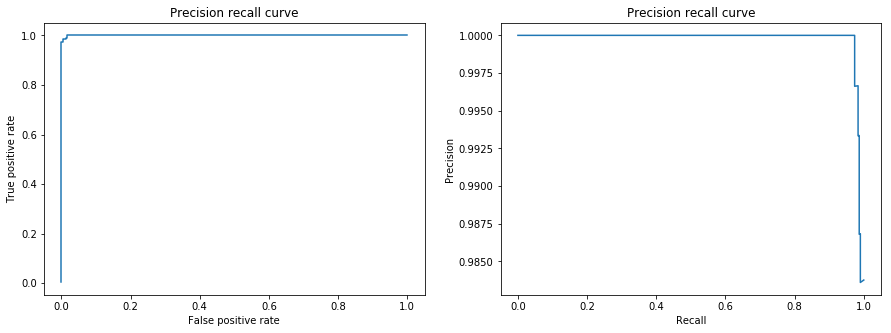

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
p, r, _ = precision_recall_curve(y_test, y_score[:, 1])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(fpr, tpr)
ax1.set_title("Precision recall curve")
ax1.set_xlabel("False positive rate")
ax1.set_ylabel("True positive rate")

ax2.plot(r, p)
ax2.set_title("Precision recall curve")
ax2.set_ylabel("Precision")
ax2.set_xlabel("Recall")

### Бонусное задание. Обучение логистической регрессии.

[2 бонусных балла]

Если выше вручную мы только применяли логистическую регрессию, то здесь предлагается реализовать обучение с помощью полного градиентного спуска.

Если кратко, то обучение логистической регрессии с $L_2$-регуляризацией можно записать следующим образом:

$$
Q(w, X) = \frac{1}{l} \sum_{i=1}^{l} \log (1 + \exp(- y_i \langle w, x_i \rangle )) + \frac{\lambda_2}{2} \lVert w \rVert _2^2 \to \min_w
$$

Считаем, что $y_i \in \{-1, +1\}$, а нулевым признаком сделан единичный (то есть $w_0$ соответствует свободному члену). Искать $w$ будем с помощью градиентного спуска:

$$
w^{(k+1)} = w^{(k)} - \alpha \nabla_w Q(w, X)
$$

В случае полного градиентного спуска $\nabla_w Q(w, X)$ считается напрямую (как есть, то есть, используя все объекты выборки). Длину шага $\alpha > 0$ в рамках данного задания предлагается брать равной некоторой малой константе.

Градиент по объекту $x_i$ считается по следующей формуле:

$$
\nabla_w Q(w, x_i) = - \frac{y_i x_i}{1 + \exp(y_i \langle w, x_i \rangle)} + \lambda_2 w
$$

На самом деле неправильно регуляризировать свободный член $w_0$ (то есть при добавлении градиента для $w_0$ не надо учитывать слагаемое с $\lambda_2$). Но в рамках этого задания мы не обращаем на это внимания и работаем со всеми вектором весов одинаково. 

В качестве критерия останова необходимо использовать (одновременно):
- проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$) — параметр tolerance
- достижение максимального числа итераций (например, 10000) — параметр max\_iter.

Инициализировать веса можно случайным образом или нулевым вектором.

Реализуйте обучение логистической регрессии. Для удобства ниже предоставлен прототип с необходимыми методами. В `loss_history` необходимо сохранять вычисленное на каждой итерации значение функции потерь. 

In [12]:
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, lambda_2=1.0, tolerance=1e-4, max_iter=1000, alpha=1e-3):
        """
        lambda_2: L2 regularization param
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        alpha: learning rate
        """
        self.lambda_2 = lambda_2
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.alpha = alpha
        self.w = None
        self.loss_history = None
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        self.loss_history = []
        
        pass
        
        return self
    
    def predict_proba(self, X):
        """
        X: np.array of shape (l, d)
        ---
        output: np.array of shape (l, 2) where
        first column has probabilities of -1
        second column has probabilities of +1
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        pass
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        pass

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        pass

1. Примените логистическую регресиию на той же выборке.
2. Посчитайте качество по тем же метрикам.
3. Визуализируйте изменение значений функции потерь от номера итераций.

In [13]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Случайные леса.

[6 баллов]

Случайный лес — алгоритм машинного обучения, представляющий собой бэггинг над решающими деревьями (усреднение ответов множества слабых алгоритмов) с 2 основными идеями:
- Использование подмножества признаков при построении каждого сплита дерева.
- Бутстрап обучающей выборки для построения каждого дерева (с повторениями).

В этом задании мы попробуем оценить пользу каждой из идей. Будем использовать ту же выборку с тем же разбиением на 2 части. Для начала обучите решающее дерево `DecisionTreeClassifier` из scikit-learn и посчитайте ROC-AUC и Accuracy (порог 0.5). Не забудьте зафикиксировать сид для построения дерева (несмотря на то, что в классической реализации никакой случайности нет, при большой глубине дерева может возникать неоднозначность в выборке признака в сплите). Используйте этот сид для всех заданий ниже.

In [14]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_tr_score = clf.predict_proba(X_test)[:, 1]
y_tr_pred = 1 * (y_tr_score > 0.5)


print("accuracy score: {0}".format(accuracy_score(y_test, y_tr_pred)))
print("roc-auc score : {0}".format(roc_auc_score(y_test, y_tr_score)))

accuracy score: 0.935
roc-auc score : 0.934910157682435


### 2.1 Бэггинг классификаторов

Реализуйте бэггинг над решающими деревьями (усреднение предсказанных вероятностей всего ансамбля). 
В качестве основы используйте всё тот же `DecisionTreeClassifier`. Количество базовых алгоритмов предлагается брать равным 100. 

Посчитайте качество с помощью тех же метрик. Ответьте на следующие вопросы:
- Что интересного вы видите?
- С чем это связано?

In [15]:
forest_pred = []
subsample_size = 800
for i in range(100):
    seq = np.random.permutation(X_train.shape[0])[:subsample_size]
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(np.array(X_train)[seq], np.array(y_train)[seq])
    forest_pred.append(tree.predict_proba(X_test)[:, 1])
    
ans = np.mean(np.array(forest_pred), 0)
ans_pred = 1*(ans > 0.5)
print("accuracy score: {0}".format(accuracy_score(y_test, ans_pred)))
print("roc-auc score : {0}".format(roc_auc_score(y_test, ans)))

accuracy score: 0.9633333333333334
roc-auc score : 0.9924492449244925


 - Качество алгоритма возрасло (параметры accuracy и roc-auc стали больше, чем при обучении одного дерева)
 - Это связано с тем, что процедура бэггинг показывает высокий прирост обобщающей способности по сравнению с алгоритмом, обученным с помощью базового метода по исходной обучающей выборке, в тех случаях, когда вариационная составляющая ошибки базового метода высока. К таким моделям относятся в частности решающие деревья и нейросетевые методы. При использовании в качестве базового метода решающих деревьев процедура бэггинг приводит к построению ансамблей решающих деревьев (решающих лесов).

### 2.2 Сэмплирование обучающей выборки

Добавим к нашему бэггингу бутстрап выборки (генерация случайной выборки того же размера с возвращением). Для этого может пригодиться `numpy.random.randint`.

Посчитайте качество. Что вы видите?

In [17]:
np.random.seed(123)  # для одинакового бутстрапа в каждом запуске

forest_pred = []
subsample_size = X_train.shape[0]
for i in range(100):
    seq = numpy.random.randint(0, X_train.shape[0], X_train.shape[0])[:subsample_size]
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(np.array(X_train)[seq], np.array(y_train)[seq])
    forest_pred.append(tree.predict_proba(X_test)[:, 1])
    
ans = np.mean(np.array(forest_pred), 0)
ans_pred = 1*(ans > 0.5)
print("accuracy score: {0}".format(accuracy_score(y_test, ans_pred)))
print("roc-auc score : {0}".format(roc_auc_score(y_test, ans)))

accuracy score: 0.96
roc-auc score : 0.9929937438188263


- Качество алгоритма возрасло по метрике roc-auc и упало по accuracy в сравнении с бэггингом классификаторов без семплирования обучающей выборки 

### 2.3 Выбор случайного подмножества признаков

Временно забудем о бутстрапе выборки и добавим выбор случайного подмножества признаков при построении каждого сплита. В `DecisionTreeClassifier` за это отвечает параметр `max_features`. По умолчанию он имеет значение `None`, что обозначает использование всех возможных признаков. Для задачи классификации рекоменуется использовать квадратный корень от количества признаков. Попробуйте выставить такое значение. На этот раз надо отключить фиксированный сид в построении дерева, так как иначе каждый раз мы будем выбирать одинаковые подмножества признаков. 

Посчитайте качество. Что вы видите?

In [16]:
import math
np.random.seed(123)  # для воспроизводимости построения случайных подмножеств признаков

forest_pred = []
max_feat = int(math.sqrt(X_train.shape[1]))

subsample_size = 800
for i in range(100):
    tree = DecisionTreeClassifier(max_features=max_feat)
    tree.fit(np.array(X_train), np.array(y_train))
    forest_pred.append(tree.predict_proba(X_test)[:, 1])
    
ans = np.mean(np.array(forest_pred), 0)
ans_pred = 1*(ans > 0.5)
print("accuracy score: {0}".format(accuracy_score(y_test, ans_pred)))
print("roc-auc score : {0}".format(roc_auc_score(y_test, ans)))

accuracy score: 0.955
roc-auc score : 0.9918769654743252


 - Качество алгоритма выше, чем у одного обученного дерева, но ниже, чем при бэггинге классификатора по всем измеряемым метрикам (accuracy и roc-auc)

### 2.4 = 2.2 + 2.3

Объединим два подхода (бутстрап + выбор подмножества признаков). Получим случайный лес.

Посчитайте качество. Что вы видите?

In [21]:
import math
np.random.seed(123)  # для одинакового бутстрапа и выбора подмножеств признаков в каждом запуске

forest_pred = []
max_feat = int(math.sqrt(X_train.shape[1]))

subsample_size = 800
for i in range(100):
    seq = np.random.permutation(X_train.shape[0])[:subsample_size]
    tree = DecisionTreeClassifier(max_features=max_feat)
    tree.fit(np.array(X_train)[seq], np.array(y_train)[seq])
    forest_pred.append(tree.predict_proba(X_test)[:, 1])
    
ans = np.mean(np.array(forest_pred), 0)
ans_pred = 1*(ans > 0.5)
print("accuracy score: {0}".format(accuracy_score(y_test, ans_pred)))
print("roc-auc score : {0}".format(roc_auc_score(y_test, ans)))

accuracy score: 0.965
roc-auc score : 0.9935437988243269


 - Модель обладает самым высоким accuracy и roc-auc. 

То, что мы сделали уже реализовано в `RandomForestClassifier`. Попробуйте воспользоваться им. Количество используемых деревьев передаётся в параметре `n_estimators`.

Посчитайте качество. Что вы видите?

In [22]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(123)  # для одинакового бутстрапа и выбора подмножеств признаков в каждом запуске


rfc = RandomForestClassifier(n_estimators=100, max_features=4)
rfc.fit(X_train, y_train)

rfc_score = rfc.predict_proba(X_test)[:, 1]
rfc_pred = 1*(rfc_score > 0.5)


print("accuracy score: {0}".format(accuracy_score(y_test, rfc_pred)))
print("roc-auc score : {0}".format(roc_auc_score(y_test, rfc_score)))

accuracy score: 0.9616666666666667
roc-auc score : 0.993727150492827


 - Метрики качества немного отличаются, связано с тем, что модель из sklearn устроена сложнее, чем созданная нами

### 2.5 Влияние количества используемых деревьев в случайном лесе

Один из параметров случайного леса — количество деревьев, используемых в бэггинге. Оценим, как влияет этот параметр на финальное качество. Для этого обучите случайные леса с разным количество деревьев (например, перебирайте от 10 до 1000 с шагом в 10), оцените качество с помощью ROC-AUC. Постройте график зависимости ROC-AUC от количества используемых деревьев. Что вы видите?

In [24]:
roc_auc = []
x = []

for i in range(10, 1010, 10):
    rfc = RandomForestClassifier(n_estimators=i, max_features=4)
    rfc.fit(X_train, y_train)

    rfc_score = rfc.predict_proba(X_test)[:, 1]
    rfc_pred = 1*(rfc_score > 0.5)

    x.append(i)
    roc_auc.append(roc_auc_score(y_test, rfc_score))

Text(0,0.5,'roc-auc')

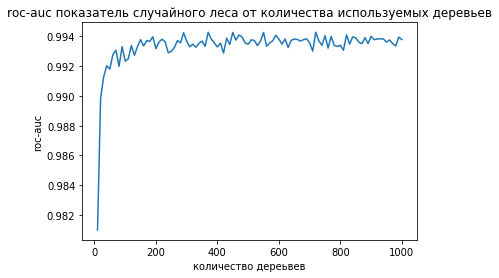

In [27]:
plt.plot(x, roc_auc)
plt.title('roc-auc показатель случайного леса от количества используемых деревьев')
plt.xlabel('количество дереьвев')
plt.ylabel('roc-auc')

 - roc-auc показатель стремительно растёт при количестве деревьев в промежутке от 10 до 200, после этого график становится пологим с некоторыми колебаниями, это говорит о том, что у случайного дерева есть асимптота качества по метрике auc-roc от количества используемых деревьев, а это значит, что достаточно обучить 200 деревьев и результат будет примерно такой же, как если бы мы обучили более 200 деревьев

### 2.6 Важность признаков

Случайный лес позволяет оценить важность признаков. У обученного случайного леса есть аттрибут `feature_importances_`, где храниться важность для каждого признака. Постройте `barplot` с важностью признаков (удобно использовать библиотеку `seaborn`, где можно для каждого столбца передать название признака `train.columns`).

Text(0.5,0,'Важность')

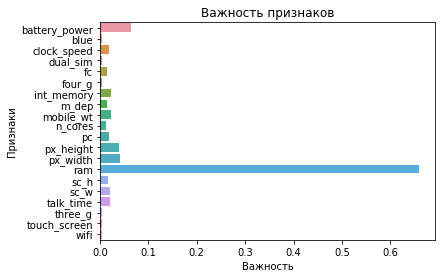

In [31]:
import seaborn as sns

rfc = RandomForestClassifier(n_estimators=100, max_features=max_feat)
rfc.fit(X_train, y_train)

ax = plt.axes()
sns.barplot(y=train.columns[:-1], x=rfc.feature_importances_, ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel("Признаки")
ax.set_xlabel("Важность")


## Выводы

Напишите, что интересного вы узнали в этой работе, в каких экспериментах какие результаты получились.

- Мы обучили три типа моделей : логистическую регрессию, решающее дерево и случайный лес и сравнивали качество этих алгоритмов по двум метрикам : accuracy и roc-auc
    - Наилучший результат показала логистическая регрессия
- При рассмотрении случайного леса мы сравнивали различные подходы : строили решающее дерево, использовали бэггинг над 100 решающими деревьями, делали семплирование обучающей выборки и выбор случайного множества признаков и сравнивали полученные модели с стандартной из библиотеки sklearn
    - При выборе подмножества признаков их количество стоит принять как корень квадратный от количества признаков
    - Комбинация всех методов (бэггинг, бутстрап выборки и выбор подмножества признаков) даёт лучший результат по accuracy и auc-roc
    - Полученная итоговая модель случайного леса отличается от стандартной из библиотеки, потому что последняя устроена сложнее, чем реализованная нами
- В работе была рассмотрено влияние количества используемых деревьев на качество алгоритма по метрике auc-roc. Было установлено, что у качества есть асимптота и при определённом количестве деревьев значительного выигрыша в качестве не получить, это одно из важнейших свойств случайного леса, которое ограничивает итерации, необходимые для получения оптимальной модели
- Также было рассмотрено свойство случайного леса по нахождению важных признаков, это является большим плюсом алгоритма, так как позволяет интерпретировать его результат, в нашем примере самым важным признаком оказалось количество оперативной памяти в телефоне далее объем батареи, но он выделяется не так, как первый признак. 